# **Handwritten Digits Recognition**

## **Sommaire**

1. [Introduction](#1.-Introduction)  
2. [Présentation de la base de données MNIST](#2.-Présentation-de-la-base-de-données-MNIST)  
3. [Classification des données MNIST par réseau multicouches](#3.-Classification-des-données-MNIST-par-réseau-multicouches)  
4. [Classification par réseau multicouches avec convolution](#4.-Classification-par-réseau-multicouches-avec-convolution)  
5. [Démonstration : Reconnaissance de chiffres manuscrits avec un réseau multicouches](#5.-Démonstration--Reconnaissance-de-chiffres-manuscrits-avec-un-réseau-multicouches)  
6. [Conclusion](#6.-Conclusion)

## **1. Introduction**

Dans ce notebook, nous allons explorer l'utilisation du **Deep Learning** pour résoudre un problème classique de **reconnaissance de chiffres écrits à la main**.

Pour ce faire, nous allons utiliser la **base de données MNIST**, qui est une **base de données de chiffres manuscrits** couramment utilisée pour la l'entraînement et l'évaluation des **modèles de reconnaissance de chiffres**. Nous allons d'abord implémenter une **classification des données MNIST** en utilisant un **réseau multicouche**, puis nous allons explorer une approche plus avancée en utilisant un **réseau multicouche** avec **convolution**.

Enfin, nous allons présenter une **démonstration de nos résultats** et discuter de l'efficacité de nos modèles. Cela nous permettra de mieux comprendre les avantages et les inconvénients de chaque approche et de mieux comprendre comment le **Deep Learning** peut être utilisé pour résoudre des **problèmes de classification** complexes.

In [1]:
# Importation
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.datasets import mnist, boston_housing
from keras import models
from keras import layers
from keras import Input

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

## **2. Présentation de la base de données MNIST**

Dans cette partie, nous avons importé le **dataset MNIST** fourni par `Keras`, qui contient une **base d'entraînement** et une **base de test**. La **base d'entraînement** contient **60 000 images** et la **base de test** en contient **10 000 images**.

In [2]:
# Charger des images d'entraînement et de test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# Afficher les dimensions du dataset d'entraînement et de test
print("Dimension du dataset d'entraînement :", train_images.shape)
print("Dimension du dataset de test:", test_images.shape)

Dimension du dataset d'entraînement : (60000, 28, 28)
Dimension du dataset de test: (10000, 28, 28)


In [4]:
# Afficher le nombre de classes (chiffres) dans le jeu de données
num_classes = len(set(train_labels))
print("Nombre de classes :", num_classes)

Nombre de classes : 10


In [5]:
# Afficher la distribution des chiffres dans le jeu de données d'entraînement
for i in range(num_classes):
    count_train = len(train_labels[train_labels==i])
    count_test = len(test_labels[test_labels==i])
    count_total = len(train_labels[train_labels==i]) + len(test_labels[test_labels==i])
    print("Class {}: {} images d'entraînement and {} images de test".format(i, count_train, count_test))

Class 0: 5923 images d'entraînement and 980 images de test
Class 1: 6742 images d'entraînement and 1135 images de test
Class 2: 5958 images d'entraînement and 1032 images de test
Class 3: 6131 images d'entraînement and 1010 images de test
Class 4: 5842 images d'entraînement and 982 images de test
Class 5: 5421 images d'entraînement and 892 images de test
Class 6: 5918 images d'entraînement and 958 images de test
Class 7: 6265 images d'entraînement and 1028 images de test
Class 8: 5851 images d'entraînement and 974 images de test
Class 9: 5949 images d'entraînement and 1009 images de test


In [6]:
# Affichage de la taille d'une image de la base de données MNIST
print("Taille d'une image :", train_images[0].shape)

# Affichage de la valeur minimale des pixels dans la base de données MNIST
print("Valeur minimale des pixels :", train_images.min())

# Affichage de la valeur maximale des pixels dans la base de données MNIST
print("Valeur maximale des pixels :", train_images.max())

Taille d'une image : (28, 28)
Valeur minimale des pixels : 0
Valeur maximale des pixels : 255


Dans cette partie ci-dessous, nous avons défini la **taille d'un lot d'images** (batch_size) pour **augmenter la vitesse d'entraînement du réseau**. Les lots sont des regroupements d'images, et dans cet exemple, nous avons créé un lot de taille 10. Cela permet de **traiter plusieurs images simultanément** plutôt que de traiter chaque image individuellement, ce qui **accélère le temps d'entraînement**.

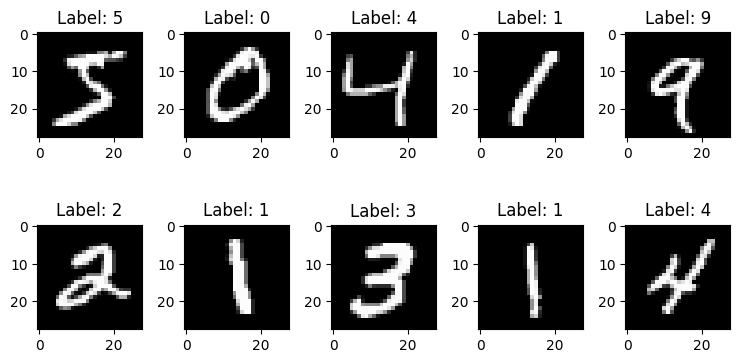

In [7]:
# Définir la taille d'un lot d'images
batch_size = 10

# Définir l'indice de départ
n_batch = 0

# Extraire un lot d'images et d'étiquettes à partir de la base de données
images = train_images[n_batch:batch_size+n_batch]
labels = train_labels[n_batch:batch_size+n_batch]

# Définir le nombre de lignes et de colonnes pour afficher les images
num_row, num_col = 2, 5

# Créer une figure avec des sous-figures pour afficher les images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))

# Afficher chaque image avec son étiquette dans une sous-figure
for i in range(batch_size):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
    
# Régler l'espace entre les sous-figures et afficher la figure
plt.tight_layout()
plt.show()

## **3. Classification des données MNIST par réseau multicouches**

Dans cette partie, nous allons explorer la **classification des données MNIST** en utilisant un **réseau multicouches**. Les **données MNIST** sont un ensemble de **60 000 images de chiffres manuscrits**, chacune étiquetée avec son chiffre correspondant de 0 à 9. 

### **Prétraitement des données**

Avant de pouvoir entraîner notre **réseau neuronal**, nous devons effectuer un prétraitement sur les données. Tout d'abord, nous avons dû **remodeler les images d'entraînement et de test** pour les mettre sous la forme d'un vecteur de 784 dimensions (28 * 28). Ensuite, nous avons converti les **pixels en nombres flottants** et **normalisé les valeurs des pixels** des images en les divisant par 255.

Nous avons également dû convertir les **étiquettes des données en vecteurs de catégories** pour les adapter à notre modèle de réseau neuronal. Nous avons utilisé la fonction `to_categorical` de `Keras` pour effectuer cette conversion.

Il est important de noter que les **étiquettes d'origine de notre base de données MNIST** contenaient des nombres entiers représentant les **chiffres de 0 à 9**. Cependant, pour entraîner notre **réseau neuronal**, nous devons convertir ces **étiquettes en vecteurs de catégories** qui correspondent à chacune des classes possibles dans notre ensemble de données.

In [8]:
# Reshape les images d'entraînement et de test pour les mettre sous la forme d'un vecteur de 784 dimensions (28*28)
train_images = train_images.reshape((60000, 28 * 28))
test_images = test_images.reshape((10000, 28 * 28))

In [9]:
# Conversion des pixels en float et normalisation des pixels des images
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [10]:
# Afficher l'étiquette avant conversion
print("Étiquette avant conversion: ", train_labels[0])

# Convertir les étiquettes en vecteurs de catégories
num_classes = len(set(train_labels))
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# Afficher l'étiquette après conversion
print("Étiquette après conversion: ", train_labels[0])

Étiquette avant conversion:  5
Étiquette après conversion:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### **Création du modèle : réseau multicouches**

Dans cette étape, nous avons créé notre **modèle de réseau de neurones séquentiel** à l'aide de la bibliothèque `Keras`. Notre modèle est constitué d'une **couche de neurones** densément connectés avec une **activation "relu"**, suivie d'une couche de sortie avec une **activation "softmax"** pour la classification multi-classes.

Ensuite, nous avons compilé notre modèle en utilisant la **fonction d'optimisation "adam"**, la **fonction de perte "categorical_crossentropy"** et la **métrique de performance "accuracy"**.

In [11]:
# Création du modèle de réseau de neurones séquentiel
mlp_model = models.Sequential()

# Ajoute d'une couche de neurones densément connectés avec activation relu
mlp_model.add(Input(shape=(28 * 28,)))
mlp_model.add(layers.Dense(512, activation='relu'))

# Ajoute d'une couche de sortie avec activation softmax pour la classification multi-classes
mlp_model.add(layers.Dense(10, activation='softmax'))

# Compilation du modèle avec la fonction d'optimisation adam, la fonction de perte categorical_crossentropy et la métrique de performance accuracy
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Affiche un résumé de l'architecture du réseau
mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### **Entraînement du modèle : réseau multicouches**

Nous avons ensuite entraîné notre modèle en utilisant les données d'entraînement. Nous avons choisi de faire **12 epochs** avec une **taille de batch de 1000**. 

In [13]:
# Entraînement du modèle sur les données d'entraînement
history_mlp = mlp_model.fit(train_images, train_labels, epochs=12, batch_size=1000)

Epoch 1/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7420 - loss: 0.9478
Epoch 2/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9320 - loss: 0.2436
Epoch 3/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9509 - loss: 0.1767
Epoch 4/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9618 - loss: 0.1380
Epoch 5/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9697 - loss: 0.1079
Epoch 6/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9750 - loss: 0.0911
Epoch 7/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9782 - loss: 0.0786
Epoch 8/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9833 - loss: 0.0637
Epoch 9/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9851 - loss: 0.0566
Epoch 10/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9871 - loss: 0.0504
Epoch 11/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9894 - loss: 0.0432
Epoch 12/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy:

In [14]:
# Affiche les métriques d'entraînement stockées dans history
history_mlp.history.keys()

dict_keys(['accuracy', 'loss'])

In [15]:
# Évaluation des performances du modèle sur les données d'entraînement
train_loss, train_acc = mlp_model.evaluate(train_images, train_labels)
print('Train accuracy:', train_acc)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9929 - loss: 0.0331
Train accuracy: 0.9922333359718323


Text(0.5, 0, 'Epochs')

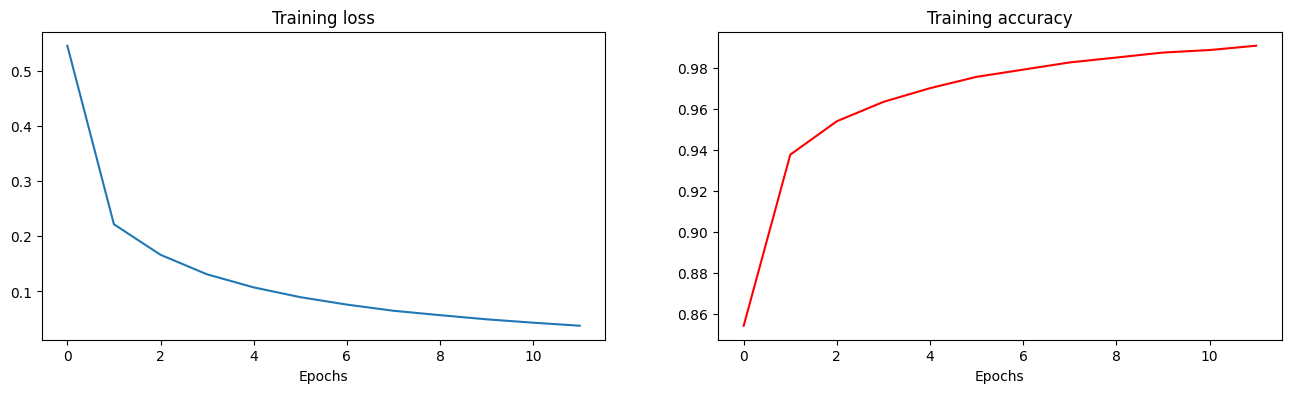

In [16]:
# Création d'une figure à deux sous-figures pour afficher les résultats d'entraînement
f, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))

# Trace la courbe de perte (loss) d'entraînement
ax1.plot(history_mlp.history['loss'])
ax1.set_title('Training loss')
ax1.set_xlabel('Epochs')

# Trace la courbe de précision (accuracy) d'entraînement
ax2.plot(history_mlp.history['accuracy'],'r')
ax2.set_title('Training accuracy')
ax2.set_xlabel('Epochs')

Ensuite, nous avons évalué les **performances du modèle** sur les données d'entraînement en calculant la **perte (loss)** et **l'exactitude (accuracy)** en utilisant la **méthode "evaluate"** de `Keras`. Nous avons affiché la **précision d'entraînement (train accuracy)** dans la console.

On a ensuite créé deux graphes pour afficher les résultats d'entraînement, la **courbe de perte d'entraînement** et la **courbe d'exactitude (accuracy)** d'entraînement. La **courbe de perte (loss)** est représentée en bleu et la **courbe de précision (accuracy)** en rouge. Les axes x représentent le nombre d'epochs et les axes y représentent les valeurs de perte et de précision.

### **Prédiction**

Après avoir entraîné le modèle de **réseau multicouches** sur les données d'entraînement, nous pouvons l'utiliser pour **prédire les chiffres** correspondants aux images de l'ensemble de test. Nous utilisons la **méthode predict()** du modèle pour obtenir les prédictions pour toutes les images de l'ensemble de test. Ensuite, nous pouvons afficher la prédiction la plus probable pour la première image de test en utilisant la **fonction argmax()** de `NumPy`.

In [17]:
# Utilisation du modèle entraîné pour prédire des chiffres sur l'ensemble de test
predictions = mlp_model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


In [18]:
# Affichage des dimensions de la première prédiction
print("Dimensions :", predictions[0].shape)

# Affichage de la somme des probabilités de la première prédiction
print("Probabilités :", np.sum(predictions[0]))

# Affichage de la prédiction la plus probable pour la première image de test
print("Prédiction :", np.argmax(predictions[0]))

Dimensions : (10,)
Probabilités : 1.0
Prédiction : 7


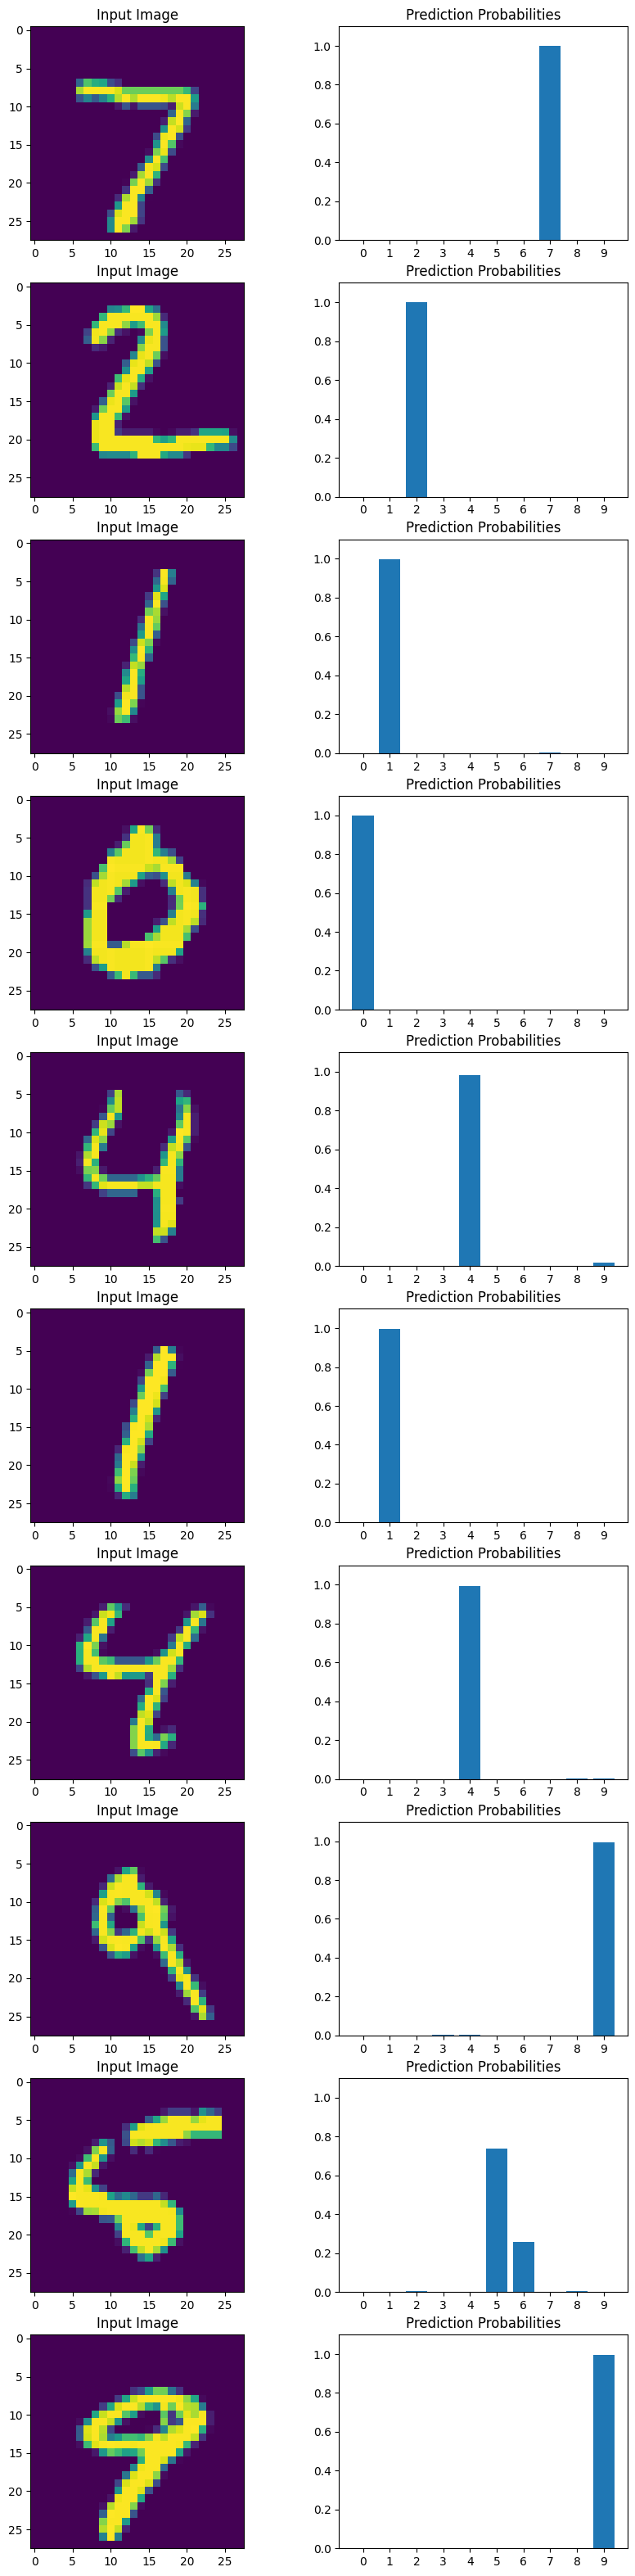

In [19]:
# Index de l'image de test à afficher
n = 0

# Sélection des entrées (inputs) et sorties (outputs) correspondant à l'image n
inputs = test_images[n * batch_size: (n + 1) * batch_size, :].reshape(batch_size, 28, 28)
outputs = predictions[n * batch_size: (n + 1) * batch_size, :]

# Création d'une figure pour afficher les entrées et les sorties
fig, axes = plt.subplots(batch_size, 2, figsize=(10, 4 * batch_size))

# Boucle sur les images de l'ensemble de test sélectionnées
for i in range(batch_size):
    # Affichage de l'image d'entrée
    axes[i, 0].imshow(inputs[i, :, :])
    axes[i, 0].set_title("Input Image")
    
    # Affichage de la distribution de probabilités pour la prédiction de l'image
    axes[i, 1].bar(range(10), outputs[i, :])
    axes[i, 1].set_title("Prediction Probabilities")
    axes[i, 1].set_xticks(range(10))
    axes[i, 1].set_ylim((0, 1.1))
    
# Affichage de la figure
plt.show()

Le code affiche une image de l'ensemble de test du **modèle de réseau de neurones** entraîné pour reconnaître les chiffres manuscrits. Il montre l'image d'entrée et la distribution de probabilités pour la prédiction de l'image, en utilisant une barre verticale pour représenter chaque chiffre possible et sa probabilité respective. Cela permet de visualiser comment le modèle classe les images de chiffres manuscrits.

### **Validation**

In [20]:
# Évaluation des performances du modèle sur l'ensemble de test
test_loss, test_acc = mlp_model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9748 - loss: 0.0824
Test accuracy: 0.9789999723434448


Les résultats obtenus sont satisfaisants.

### **Performances en reconnaissance : Validation croisée k-fold**

In [21]:
# Définir le modèle MLP
def create_model():
    model = models.Sequential()
    model.add(Input(shape=(28 * 28,)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
# Définition du nombre de folds pour la validation croisée
k = 5

# Création d'une liste pour stocker les scores
scores = []

# Instanciation de la validation croisée KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Boucle sur chaque fold pour entraîner et évaluer le modèle
for train_index, val_index in kf.split(train_images):
  
  model = create_model() # Création du modèle de réseau de neurones séquentiel

  # Sélection des données d'entraînement et de validation pour le fold courant
  train_images_fold, train_labels_fold = train_images[train_index], train_labels[train_index]
  val_images_fold, val_labels_fold = train_images[val_index], train_labels[val_index]

  # Entraînement du modèle sur les données d'entraînement pour le fold courant
  history = model.fit(
      train_images_fold, 
      train_labels_fold, 
      epochs=12, batch_size=1000, 
      validation_data=(val_images_fold, val_labels_fold), 
      verbose=0
  )

  # Évaluation des performances du modèle sur les données de validation pour le fold courant
  _, fold_score = model.evaluate(
      val_images_fold, 
      val_labels_fold, 
      verbose=0
  )
  
  # Ajout du score du fold courant à la liste des scores
  scores.append(fold_score)

# Calcul de la moyenne et de l'écart type des scores
mean_score = np.mean(scores)
std_score = np.std(scores)

# Affichage des performances moyennes et écart-type sur l'ensemble des folds
print('Validation accuracy: %.3f%% (+/- %.3f%%)' % (mean_score * 100, std_score * 100))

Validation accuracy: 97.278% (+/- 0.129%)


In [23]:
# Utilisation du modèle entraîné sur l'ensemble d'entraînement pour prédire des chiffres sur l'ensemble de test
predictions = model.predict(test_images)

# Évaluation des performances du modèle sur l'ensemble de test
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9692 - loss: 0.0961
Test accuracy: 0.9736999869346619


## **4. Classification par réseau multicouches avec convolution**

Dans cette partie, nous allons explorer l'utilisation des **réseaux multicouches avec convolution** pour la **classification des données MNIST**. Nous allons commencer par charger les données et les prétraiter pour les adapter à l'entrée du modèle. Ensuite, nous allons construire un **modèle multicouche** avec des **couches de convolution** et des **couches de pooling**, ainsi qu'une **couche de sortie dense**. Nous allons entraîner le **modèle sur les données d'entraînement** et **l'évaluer sur les données de test**. Enfin, nous allons visualiser les résultats du modèle en affichant quelques exemples de prédictions sur les données de test. 

### **Chargement des images de la données MNIST**

In [24]:
# Charger les images d'entraînement et les étiquettes d'entraînement et de test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

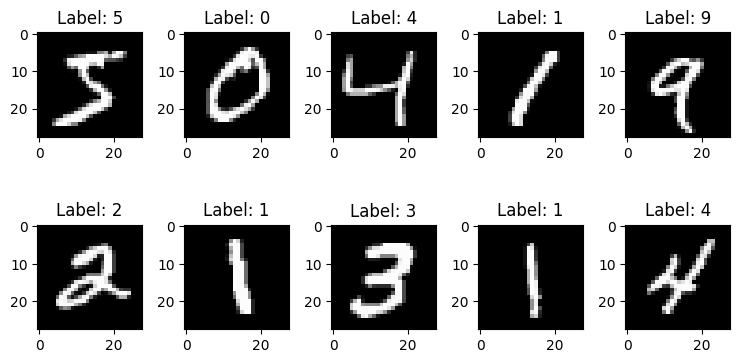

In [25]:
# Définir la taille d'un lot d'images
batch_size = 10

# Définir l'indice de départ
n_batch = 0

# Extraire un lot d'images et d'étiquettes à partir de la base de données
images = train_images[n_batch:batch_size+n_batch]
labels = train_labels[n_batch:batch_size+n_batch]

# Définir le nombre de lignes et de colonnes pour afficher les images
num_row, num_col = 2, 5

# Créer une figure avec des sous-figures pour afficher les images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))

# Afficher chaque image avec son étiquette dans une sous-figure
for i in range(batch_size):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
    
# Régler l'espace entre les sous-figures et afficher la figure
plt.tight_layout()
plt.show()

### **Prétraitement des données**

In [26]:
# Reshape les images d'entraînement et de test pour les mettre sous la forme d'un vecteur de 784 dimensions (28*28)
train_images = train_images.reshape((60000, 28 * 28))
test_images = test_images.reshape((10000, 28 * 28))

# Conversion des pixels en float et normalisation des pixels des images
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Convertir les étiquettes en vecteurs de catégories
num_classes = len(set(train_labels))
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

### **Création du modèle : réseau multicouches avec convolution**

Dans cette deuxième partie, nous allons nous concentrer sur l'implémentation d'un **réseau neuronal convolutif (CNN)**, qui est particulièrement adapté à la **reconnaissance d'images**. Contrairement à un **réseau dense**, qui cherche des motifs sur l'ensemble de l'image, un **CNN** se concentre sur de petites zones, appelées **"kernels"**, pour détecter des motifs spécifiques. Ces zones sont de taille configurable lors de l'initialisation du modèle `Keras`.

Contrairement à un **réseau fully connected**, où l'image doit être vectorisée avant d'être utilisée en entrée du réseau, un **CNN** prend directement l'image dans ses dimensions originales. Nous n'avons donc pas besoin de la transformer en un vecteur unidimensionnel.

Nous avons ici créé un **modèle de réseau multicouches avec convolution** pour la classification d'images de **chiffres manuscrits MNIST**. L'architecture du modèle comporte trois couches de **convolution avec activation ReLU**, suivies de **couches de max-pooling** pour réduire la taille de l'image en entrée. Ensuite, les caractéristiques sont aplatis et passent à travers deux couches denses pour la classification finale. Le modèle est compilé avec **l'optimiseur RMSprop** et la **fonction de perte categorical_crossentropy** pour l'apprentissage supervisé, ainsi que la métrique de précision (accuracy) pour évaluer les performances du modèle.

In [27]:
# Définition de l'architecture du réseau multicouches avec convolution
cnn_model = models.Sequential()

# Ajout explicite de la couche d'entrée
cnn_model.add(Input(shape=(28, 28, 1)))

# Ajout des couches convolutionnelles et autres
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(10, activation='softmax'))

# Compilation du modèle
cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### **Entraînement du modèle : réseau multicouches avec convolution**

In [28]:
# Entraînement du modèle sur la base de données d'apprentissage
history_cnn = cnn_model.fit(train_images.reshape((-1, 28, 28, 1)), train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 97s 95ms/step - accuracy: 0.8662 - loss: 0.4209
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 86s 92ms/step - accuracy: 0.9842 - loss: 0.0524
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 75s 79ms/step - accuracy: 0.9893 - loss: 0.0347
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 88s 86ms/step - accuracy: 0.9920 - loss: 0.0247
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - accuracy: 0.9944 - loss: 0.0181


In [29]:
# Évaluation des performances du modèle sur les données d'entraînement
train_loss, train_acc = cnn_model.evaluate(train_images.reshape(-1, 28, 28, 1), train_labels)
print('Train accuracy:', train_acc)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9954 - loss: 0.0146
Train accuracy: 0.995283305644989


Text(0.5, 0, 'Epochs')

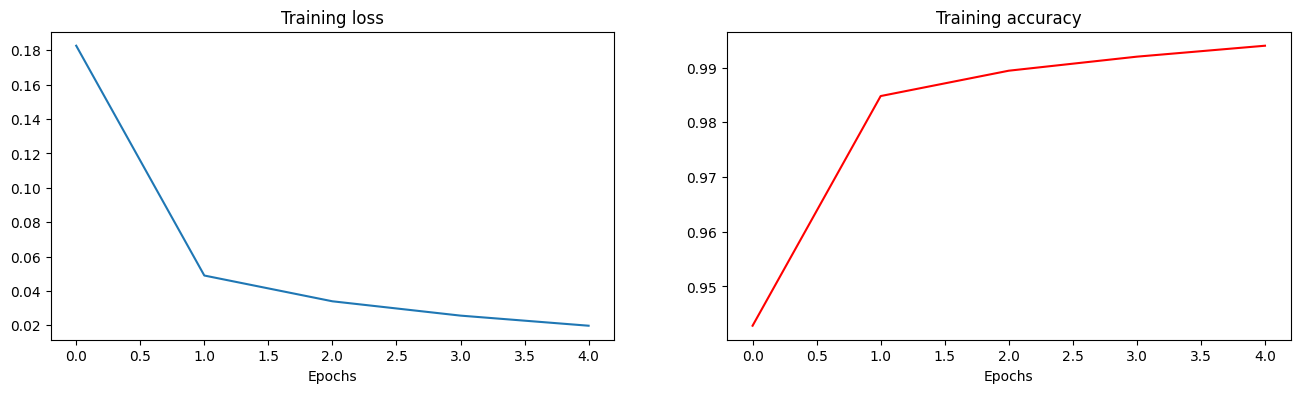

In [30]:
# Création d'une figure à deux sous-figures pour afficher les résultats d'entraînement
f, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))

# Trace la courbe de perte (loss) d'entraînement
ax1.plot(history_cnn.history['loss'])
ax1.set_title('Training loss')
ax1.set_xlabel('Epochs')

# Trace la courbe de précision (accuracy) d'entraînement
ax2.plot(history_cnn.history['accuracy'],'r')
ax2.set_title('Training accuracy')
ax2.set_xlabel('Epochs')

### **Prédiction**

In [31]:
# Redimensionner les images de test dans la forme attendue
test_images = test_images.reshape(-1, 28, 28, 1)

# Utilisation du modèle entraîné pour prédire des chiffres sur l'ensemble de test
predictions = cnn_model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [32]:
# Affichage des dimensions de la première prédiction
print("Dimensions :", predictions[0].shape)

# Affichage de la somme des probabilités de la première prédiction
print("Probabilités :", np.sum(predictions[0]))

# Affichage de la prédiction la plus probable pour la première image de test
print("Prédiction :", np.argmax(predictions[0]))

Dimensions : (10,)
Probabilités : 1.0000001
Prédiction : 7


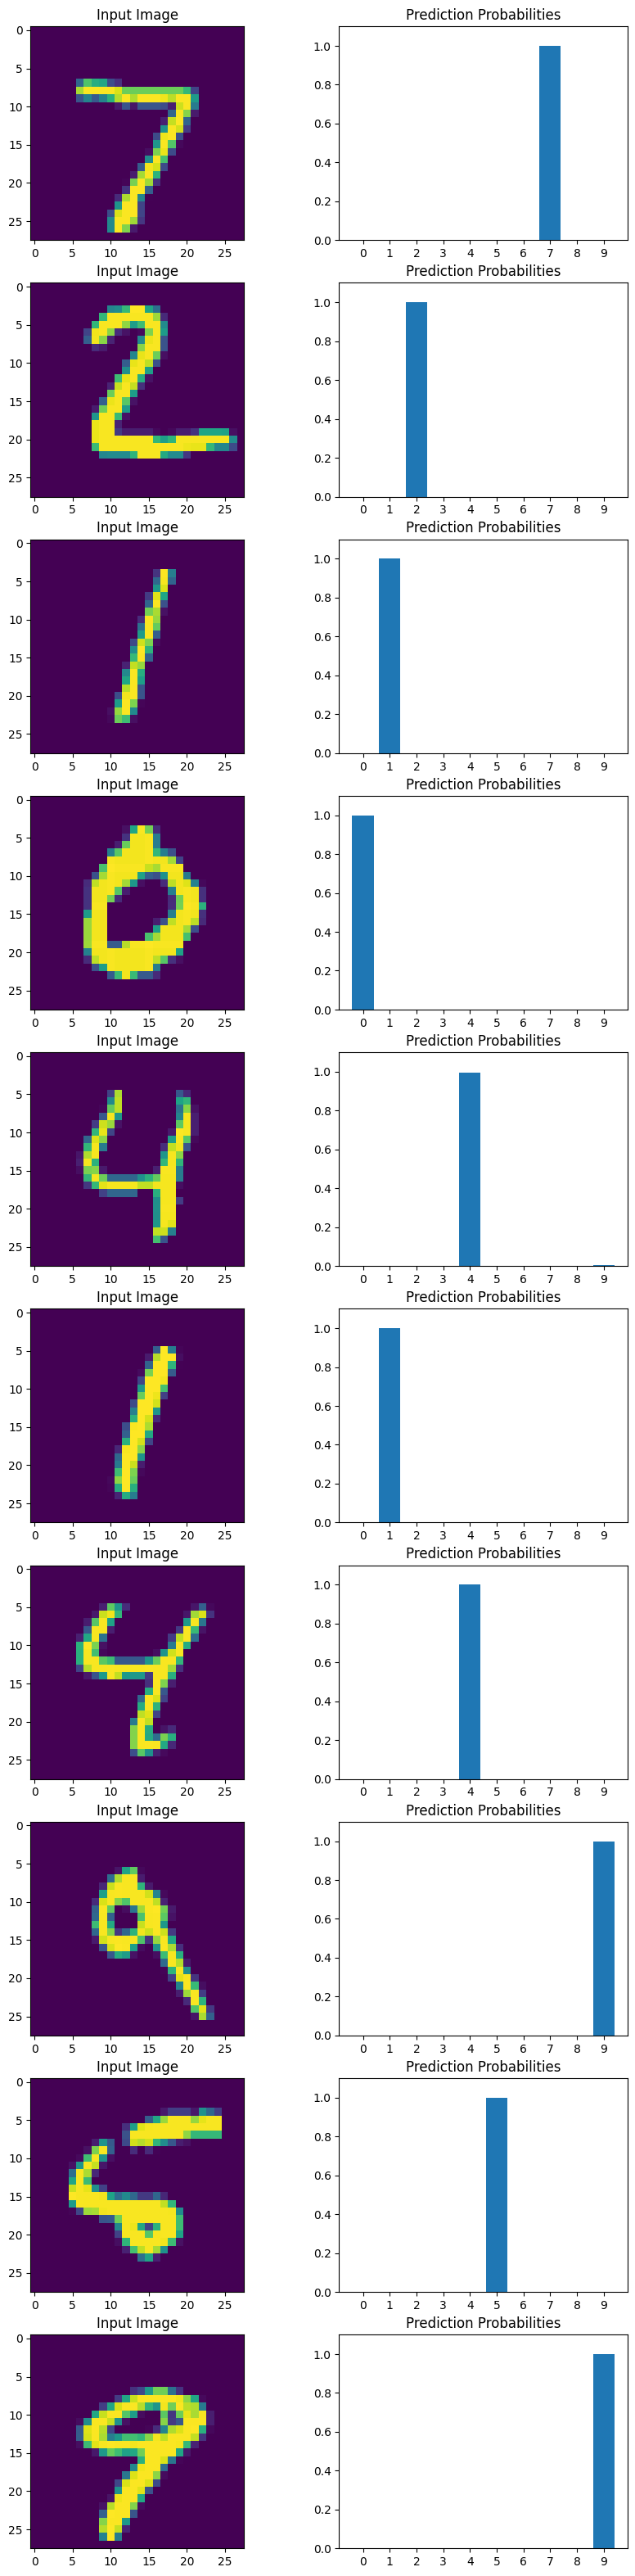

In [33]:
# Index de l'image de test à afficher
n = 0

# Sélection des entrées (inputs) et sorties (outputs) correspondant à l'image n
inputs = test_images[n * batch_size: (n + 1) * batch_size, :].reshape(batch_size, 28, 28)
outputs = predictions[n * batch_size: (n + 1) * batch_size, :]

# Création d'une figure pour afficher les entrées et les sorties
fig, axes = plt.subplots(batch_size, 2, figsize=(10, 4 * batch_size))

# Boucle sur les images de l'ensemble de test sélectionnées
for i in range(batch_size):
    # Affichage de l'image d'entrée
    axes[i, 0].imshow(inputs[i, :, :])
    axes[i, 0].set_title("Input Image")
    
    # Affichage de la distribution de probabilités pour la prédiction de l'image
    axes[i, 1].bar(range(10), outputs[i, :])
    axes[i, 1].set_title("Prediction Probabilities")
    axes[i, 1].set_xticks(range(10))
    axes[i, 1].set_ylim((0, 1.1))
    
# Affichage de la figure
plt.show()

### **Validation**

In [34]:
# Évaluation des performances du modèle sur l'ensemble de test
test_loss, test_acc = cnn_model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9877 - loss: 0.0423
Test accuracy: 0.9912999868392944


### **Validation croisée k-fold**

In [35]:
# Définir le modèle CNN
def create_model():
    model = models.Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [36]:
# Définition du nombre de folds pour la validation croisée
k = 5

# Création d'une liste pour stocker les scores
scores = []

# Instanciation de la validation croisée KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Boucle sur chaque fold pour entraîner et évaluer le modèle
for train_index, val_index in kf.split(train_images):
  
  model = create_model() # Création du modèle de réseau de neurones avec convolution

  # Sélection des données d'entraînement et de validation pour le fold courant
  train_images_fold, train_labels_fold = train_images[train_index], train_labels[train_index]
  val_images_fold, val_labels_fold = train_images[val_index], train_labels[val_index]

  # Entraînement du modèle sur les données d'entraînement pour le fold courant
  history = model.fit(
      train_images.reshape((-1, 28, 28, 1)), 
      train_labels, 
      epochs=5, 
      batch_size=64, 
      verbose=0
  )

  # Évaluation des performances du modèle sur les données de validation pour le fold courant
  _, fold_score = model.evaluate(
      val_images_fold.reshape((-1, 28, 28, 1)), 
      val_labels_fold, 
      verbose=0
  )
  
  # Ajout du score du fold courant à la liste des scores
  scores.append(fold_score)

# Calcul de la moyenne et de l'écart type des scores
mean_score = np.mean(scores)
std_score = np.std(scores)

# Affichage des performances moyennes et écart-type sur l'ensemble des folds
print('Validation accuracy: %.3f%% (+/- %.3f%%)' % (mean_score * 100, std_score * 100))

Validation accuracy: 99.575% (+/- 0.057%)


In [37]:
# Utilisation du modèle entraîné sur l'ensemble d'entraînement pour prédire des chiffres sur l'ensemble de test
predictions = model.predict(test_images)

# Évaluation des performances du modèle sur l'ensemble de test
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9859 - loss: 0.0450
Test accuracy: 0.9891999959945679


## **5. Démonstration : Reconnaissance de chiffres manuscrits avec un réseau multicouches**

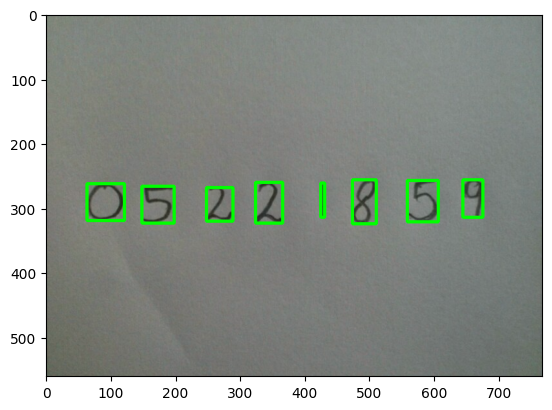

In [38]:
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt

# Lecture de l'image
im = cv2.imread("Test Images/image1.jpg")

# Convertion de l'image en niveaux de gris et appliquer le filtrage gaussien
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

# Seuil de l'image
ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

# Trouver les contours dans l'image
ctrs, hierarchy = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Obtenir des rectangles contenant chaque contour
rects = [cv2.boundingRect(ctr) for ctr in ctrs]

# Dessiner un rectangle autour des chiffres détectés
for rect in rects:
    cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3)

plt.imshow(im)
plt.show()

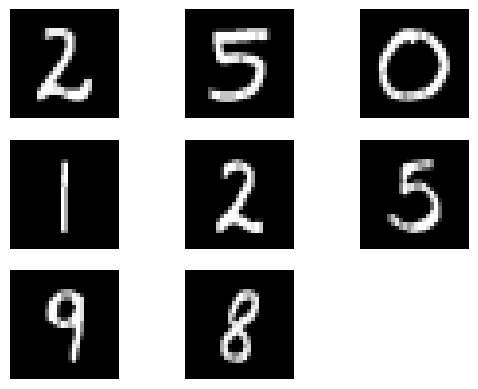

In [39]:
for i, rect in enumerate(rects):
    
    # Exctraction du chiffre
    leng = int(rect[3] * 1.6)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]
    
    # Adaptement les images en 28x28
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    
    # Affichage
    plt.subplot(3, 3, i+1)
    plt.imshow(roi, cmap='gray')
    plt.axis('off')
    
plt.show()

In [40]:
def detect_digits(image_name, model):
    
    # Lecture de l'image
    im = cv2.imread(image_name)
    
    # Convertion de l'image en niveaux de gris et appliquer le filtrage gaussien
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

    # Seuil de l'image
    ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

    # Trouver les contours dans l'image
    ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Obtenir des rectangles contenant chaque contour
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]

    # Exctraction du chiffre
    for rect in rects:
        
        # Dessiner les rectangles
        cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3)
    
        # Création de la région rectangulaire autour du chiffre
        leng = int(rect[3] * 1.6)
        pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
        pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
        roi = im_th[pt1:pt1+leng, pt2:pt2+leng]
    
        if roi.shape[0] < 28 or roi.shape[1] < 28:
            continue
        
        # Redimensionnement de l'image
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = cv2.dilate(roi, (3, 3))
        
        # Classer l'image
        roi = roi.astype('float32')
        
        # Remodeler et normaliser le "roi
        roi = roi.reshape((1, 28 * 28)) 
        roi = roi.astype('float32') /255        

        # Utiliser "modèle" pour faire une prédiction
        probas = model.predict(roi)
        
        # Sur la base de la prédiction, déterminer la classe (un nombre entre 0 et 9)
        number = np.argmax(probas[0])
        print("La prediction est :", number)
        
        # Dessiner le chiffre
        cv2.putText(im, str(number), (rect[0], rect[1]-5), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255, 0, 0), 3)

    # Affichage du résultat
    plt.imshow(im)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
La prediction est : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
La prediction est : 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
La prediction est : 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
La prediction est : 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
La prediction est : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
La prediction est : 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
La prediction est : 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
La prediction est : 8


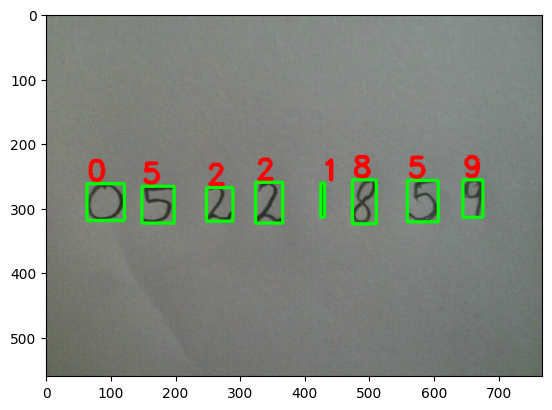

In [41]:
detect_digits("Test Images/image1.jpg", mlp_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
La prediction est : 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
La prediction est : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
La prediction est : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
La prediction est : 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
La prediction est : 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
La prediction est : 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
La prediction est : 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
La prediction est : 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
La prediction est : 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
La prediction est : 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
La prediction est : 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
La prediction est : 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
La prediction est : 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
La prediction est : 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
La prediction est : 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
La prediction est : 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
La

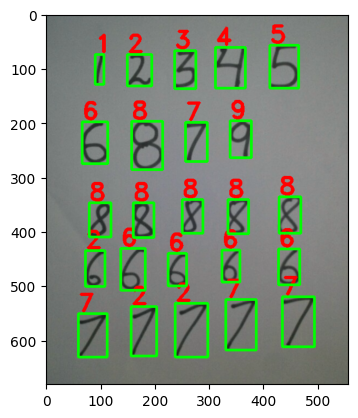

In [42]:
detect_digits("Test Images/image2.jpg", mlp_model)

## **6. Conclusion**

En conclusion, nous avons implémenté **deux modèles pour la classification des images de chiffres manuscrits MNIST** : un **réseau multicouches dense** et un **réseau multicouches avec convolution (CNN)**.

Le premier modèle, le **réseau multicouches dense**, a obtenu une **précision de presque 98%**, ce qui est un bon résultat mais qui peut être amélioré. Cependant, ce modèle est rapide à entraîner et à prédire, car il n'y a pas beaucoup de couches et il traite directement les pixels de l'image en tant que données d'entrée.

Le deuxième modèle, le **réseau multicouches avec convolution**, a donné de bien meilleurs résultats, avec une **précision d'un peu plus de 99%**. Ce modèle est plus complexe et plus long à entraîner, car il utilise plusieurs couches de convolution et de max-pooling pour extraire les caractéristiques des images avant de les envoyer aux couches de classification. Cependant, ce modèle est très performant sur des images et permet de reconnaître des détails plus efficacement en se concentrant sur des patterns sur de petites zones de l'image.

En somme, le **modèle CNN** est plus performant pour la **classification des images de chiffres manuscrits MNIST** que le modèle dense, mais il est plus complexe et plus long à entraîner. Le choix du modèle dépendra donc des exigences en termes de performance et de temps de calcul.